# Using the Lorentz Reciprocity Theorem with TMM

Ekaterina Zossimova | June 2021

### Set up

These scripts have been tested in the following environment:
* Python 3.7.9
* <a href="https://pypi.org/project/tmm/">tmm 0.1.8</a>
* numpy 1.19.2 
* scipy 1.5.2
* matplotlib 3.3.4

### Import 

In [1]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, position_resolved)

from reciprocity import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.integrate import quad

%matplotlib inline

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = np.pi/180

## Kretschmann configuration

This multilayer structure is known to have enhanced fields at the top interface when the incident light is in resonance with eigenmodes of the multilayer. The enhanced fields appear in the Kretschmann configuration under total internal reflection, enabling efficient dark-field spectroscopy of single particles/molecules. 

<img src="kretschmann.png" width=250 />

| Material | Refractive index @ 780nm | References |
| --- | --- |  --- |
| Water | 1.33 |  --- |
| SiO<sub>2</sub> | 1.52 |  --- |
| Au	| 0.1194+4.7347j | <a href="https://doi.org/10.1103/PhysRevX.10.011071">Au data</a> |
| Cr | 3.1243+3.4422j | <a href="https://doi.org/10.1103/PhysRevB.9.5056">Cr data</a> |
| Substrate (LaSFN9) | 1.85 | --- |

Further reading:
  
* Yu. Akimov and S. Sun, Phys. Chem. Chem. Phys., vol. 19, no. 13, pp. 8706–8714, 2017, doi: <a href="https://doi.org/10.1039/C7CP00151G">10.1039/c7cp00151g</a>.

* Y. Akimov, M. E. Pam, and S. Sun, Phys. Rev. B, vol. 96, no. 15, Oct. 2017, doi: <a href="https://doi.org/10.1103/PhysRevB.96.155433">10.1103/physrevb.96.155433</a>.

* Y. Akimov, Opt. Lett., vol. 43, no. 6, p. 1195, Mar. 2018, doi: <a href="https://doi.org/10.1364/OL.43.001195">10.1364/ol.43.001195</a>.

Can visit <a href="https://refractiveindex.info">RefractiveIndex.INFO</a> for more refractive index data. 

### Field enhancement

Calculate the angle of incidence that gives the maximum field enhancement at the position of the dipole using <a href="https://arxiv.org/abs/1603.02720">tmm code</a>.

The electric field at any given point is a superposition of the forward-moving and
backwards-moving electromagnetic waves:

\begin{equation} 
\textbf{E}(\textbf{r}) = \textbf{E}^0_f e^{i\textbf{k}_f \cdot \textbf{r}} + \textbf{E}^0_b e^{i\textbf{k}_b \cdot \textbf{r}}
\end{equation}

Here, $\textbf{k}_f$ and $\textbf{k}_b$ are the angular wavevectors for forward- and backwards-moving
waves; $\textbf{E}^0_f$ and $\textbf{E}^0_b$ are some constant vectors; and $\textbf{E}(\textbf{r})$ is the complex electric field at any given point $\textbf{r}$ within a certain layer. $E_x$ and $E_y$ and $E_z$ are the electric field amplitudes, where z is normal to the interfaces and the light rays are in the x, z plane. 

The field enhancement is defined as $|\textbf{E}|/|\textbf{E}_0|$ where $\textbf{E}_0$ is the incident field ($|\textbf{E}_0|$ = 1).

Optimized angle of incidence @ 780 nm [49.85539488]
Electric field at the position of the dipole [ 1.03426871e-08+5.18939610e-10j  0.00000000e+00+0.00000000e+00j
 -7.46574785e-10+1.48795529e-08j]


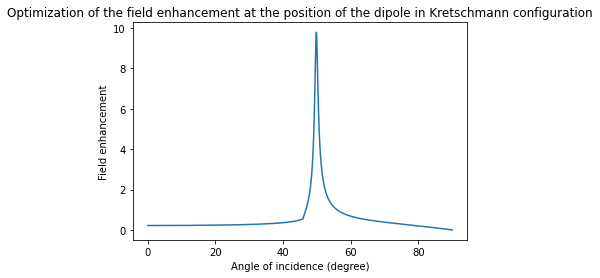

In [2]:
# List of refractive indices
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
# List of layer thicknesses in nm
d_list = [np.inf, 2, 48, 22, np.inf]
# Wavelength of incident beam
lam_vac = 780

# Calculate E-field at the position of the dipole
layer = len(d_list)-1
d_in_layer = 0

theta_list = np.linspace(0*degree, 90*degree, num=900)
field_enhancement=[]        
for theta in theta_list:
    coh_tmm_data = coh_tmm('p', n_list, d_list, theta, lam_vac)
    data = position_resolved(layer, d_in_layer, coh_tmm_data)
    Ep = np.array([data['Ex'], data['Ey'], data['Ez']])
    magnitude = np.linalg.norm(Ep)
          
    field_enhancement.append(magnitude)
    
print(f'Optimized angle of incidence @ {lam_vac} nm', theta_list[find_peaks(field_enhancement)[0]]/degree)
print(f'Electric field at the position of the dipole {Ep}')
plt.figure()
plt.plot(theta_list/degree, field_enhancement)
plt.xlabel('Angle of incidence (degree)')
plt.ylabel('Field enhancement')
plt.title('Optimization of the field enhancement at the position of the dipole in Kretschmann configuration');

### Reciprocity theorem

#### Task 1 

Use the Lorentz reciprocity theorem to calculate the far-field radiation pattern due to a particle with polarizability $\alpha = 1$ at the spacer/ water interface. 

The relationship between near-fields for s- and p- polarized light at the position of the dipole, $\textbf{r}_1$, and the radiated far-field, $\textbf{E}_{rad}$, is given by,

\begin{equation}
|\textbf{E}_{rad}(\textbf{r}_2)|^2 = |\textbf{E}_{rad}^S(\textbf{r}_2)|^2 + |\textbf{E}_{rad}^P(\textbf{r}_2)|^2 = |\textbf{E}_{near}^S(\textbf{r}_1) \cdot \textbf{p}|^2 + |\textbf{E}_{near}^P(\textbf{r}_1) \cdot \textbf{p}|^2
\end{equation}

The dipole is defined as $\textbf{p} = \alpha \textbf{E}_{max}$, where $\textbf{E}_{max}$ is the electric field at the position of the dipole (calculated for the optimized angle of incidence). 

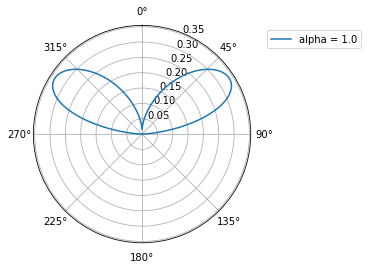

In [3]:
alpha = 1.
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.8 * degree
lam_vac = 780

ax = plt.subplot(111, projection='polar')

dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)
theta_list, poynting = radiation_pattern(dipole, n_list, d_list, lam_vac)

plotted_line = ax.plot(theta_list, poynting)
# By symmetry for negative theta
ax.plot(-theta_list, poynting, color=plotted_line[0].get_color(), label=f"alpha = {alpha}")
    
#ax.set_rmax(1.5)
#ax.set_rticks([])
ax.grid(True)
ax.set_rlabel_position(22)
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Task 2

Show that for real, scalar values of $\alpha$, that the far-field radiation is proportional to $\alpha^2$.

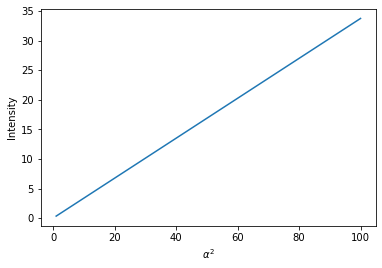

In [4]:
alpha_list = np.linspace(1., 10., 10)
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.8 * degree
lam_vac = 780

plt.figure()

intensity = []
for alpha in alpha_list:

    dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)
    theta_list, poynting = radiation_pattern(dipole, n_list, d_list, lam_vac)
    intensity.append(max(poynting))

plt.plot(alpha_list ** 2, intensity)
plt.xlabel('$α^2$')
plt.ylabel('Intensity')

plt.show()

#### Task 3 

Integrate the radiation pattern to compare the results across different multilayer stacks and particles. 

In [5]:
alpha = 1.
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.8 * degree
lam_vac = 780

dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)

res, err = quad(theta_integral, 0, np.pi/2, args=(dipole, n_list, d_list, lam_vac))
    
print("The numerical result is {:f} (+-{:g})"
        .format(res, err))

The numerical result is 1.146842 (+-1.04417e-10)
